# A1: Data Curation Assignment
### DATA512  
#### Emily Yamauchi

The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through August 30 2021. All analysis should be performed in a single Jupyter notebook. Your Jupyter notebook and your data files will be uploaded to your own GitHub repository. A link to that repository will be submitted to enable the grading of this assignment.  

The purpose of the assignment is to demonstrate that you can follow best practices for open scientific research in designing and implementing your project, and make your project fully reproducible by others: from data collection to data analysis.
For this assignment, you combine data about Wikipedia page traffic from two different [Wikimedia REST API endpoints](https://www.mediawiki.org/wiki/REST_API) into a single dataset, perform some simple data processing steps on the data, and then analyze that data.

## Step 0: Read about reproducibility

Review the chapters  "Assessing Reproducibility" and "The Basic Reproducible Workflow Template" from The Practice of Reproducible Research.

>Rokem, Marwick, and Staneva. [Assessing Reproducibility](http://www.practicereproducibleresearch.org/core-chapters/2-assessment.html) in Kitzes, J., Turek, D., & Deniz, F. (Eds.). (2018). The Practice of Reproducible Research: Case Studies and Lessons from the Data-Intensive Sciences. Oakland, CA: University of California Press.

>Kitzes. [The Basic Reproducible Workflow Template](http://www.practicereproducibleresearch.org/core-chapters/3-basic.html) in Kitzes, J., Turek, D., & Deniz, F. (Eds.). (2018). The Practice of Reproducible Research: Case Studies and Lessons from the Data-Intensive Sciences. Oakland, CA: University of California Press.

## Step 1: Data acquisition

In order to measure Wikipedia traffic from 2008-2021, you will need to collect data from two different API endpoints, the Legacy Pagecounts API and the Pageviews API.  

- The Legacy Pagecounts API ([documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts), [endpoint](https://wikimedia.org/api/rest_v1/#!/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end)) provides access to desktop and mobile traffic data from December 2007 through July 2016.
- The Pageviews API ([documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews), [endpoint](https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month.  

For each API, you will need to collect data for all months where data is available and then save the raw results into 5 separate JSON source data files (one file per API query type) before continuing to Step 2.  

To get you started, you can refer to [this example Notebook](http://paws-public.wmflabs.org/paws-public/User:Jtmorgan/data512_a1_example.ipynb) that contains sample code for API calls ([download the notebook](http://paws-public.wmflabs.org/paws-public/User:Jtmorgan/data512_a1_example.ipynb?format=raw)). This sample code is [licensed CC0](https://creativecommons.org/share-your-work/public-domain/cc0/) so feel free to reuse any of the code in that notebook without attribution.  

Your JSON-formatted source data file must contain the complete and unedited output of your API queries. The naming convention for the source data files is:  

>`apiname_accesstype_firstmonth-lastmonth.json`

For example, your filename for monthly page views for devices requesting the desktop versions of pages should be:
>`pagecounts_desktop-site_200712-202108.json`

Important notes:  
- As much as possible, we're interested in organic (user) traffic, as opposed to traffic by web crawlers or spiders. The Pageview API (but not the Pagecount API) allows you to filter by agent=user. You should do that.
- There was about 1 year of overlapping traffic data between the two APIs. You need to gather, and later graph, data from both APIs for this period of time.

In [1]:
import json
import requests

In [2]:
# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/emi90',
    'From': 'eyamauch@uw.edu'
}

# get endpoints for legacy/pageview

base = 'https://wikimedia.org/api/rest_v1/metrics/'

endpoints = {
    "pagecounts" : base + 'legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}',
    "pageviews" : base + 'pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
}

Parameters for each API call:  

- Legacy, desktop `"access-site" : "desktop-site"`
- Legacy, mobile `"access-site" : "mobile-site"`
- Pageviews, desktop `"access" : "desktop"`
- Pageviews, mobile web `"access" : "mobile-web"`
- Pageviews, mobile app `"access" : "mobile-app"`

In [3]:
# define all parameters

all_params = {
    "legacy_desktop": {
        "access" : "desktop-site",
        "data_type" : "pagecounts"},
    "legacy_mobile" : {
        "access" : "mobile-site",
        "data_type" : "pagecounts"},
    "new_desktop" : {
        "access" : "desktop",
        "data_type" : "pageviews"},
    "new_web" : {
        "access" : "mobile-web",
        "data_type" : "pageviews"},
    "new_app" : {
        "access" : "mobile-app",
        "data_type" : "pageviews"}
}

# given 

dates = {
    "pagecounts" : {
        "start" : "2007120100",
        "end" : "2016080100"},
    "pageviews" : {
        "start" : "2015070100",
        "end" : "2021100100"
    }
}

In [4]:
# function to get paramters given access type
# default to user traffic only

def get_params(access_type, agent="user"):
    
    data_type = all_params[access_type]["data_type"]
    
    if data_type == "pagecounts":
        
        params = {"project" : "en.wikipedia.org",
                  "access-site" : all_params[access_type]["access"],
                  "granularity" : "monthly",
                  "start" : dates[data_type]["start"],
                  "end" : dates[data_type]["end"]}
    
    if data_type == "pageviews":
        
        params = {"project" : "en.wikipedia.org",
                  "access" : all_params[access_type]["access"],
                  "agent" : agent,
                  "granularity" : "monthly",
                  "start" : dates[data_type]["start"],
                  "end" : dates[data_type]["end"]}
    
    return params

In [5]:
# test for api call type

get_params("new_app")

{'project': 'en.wikipedia.org',
 'access': 'mobile-app',
 'agent': 'user',
 'granularity': 'monthly',
 'start': '2015070100',
 'end': '2021100100'}

In [6]:
# function to get api response

def api_call(access_type, agent="user"):
    
    data_type = all_params[access_type]["data_type"]
    
    endpoint = endpoints[data_type]
    params = get_params(access_type, agent)
    
    call = requests.get(endpoint.format(**params), headers=headers)
    response = call.json()
    
    return response

In [7]:
# test for pageview mobile app

api_call("new_app")

{'items': [{'project': 'en.wikipedia',
   'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'timestamp': '2015070100',
   'views': 109624146},
  {'project': 'en.wikipedia',
   'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'timestamp': '2015080100',
   'views': 109669149},
  {'project': 'en.wikipedia',
   'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'timestamp': '2015090100',
   'views': 96221684},
  {'project': 'en.wikipedia',
   'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'timestamp': '2015100100',
   'views': 94523777},
  {'project': 'en.wikipedia',
   'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'timestamp': '2015110100',
   'views': 94353925},
  {'project': 'en.wikipedia',
   'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'timestamp': '2015120100',
   'views': 99438956},
  {'project': 'en.wikipedia',
   'a

In [8]:
# function to get json file and write to file

def save_json(access_type, agent="user"):
    
    resp = api_call(access_type, agent)
    path_name = "data_raw/{data_type}_{access_type}_{start}-{end}.json"
    
    data_type = all_params[access_type]["data_type"]
    
    names = {"data_type" : data_type,
            "access_type" : all_params[access_type]["access"],
            "start" : dates[data_type]["start"],
            "end" : dates[data_type]["end"]}
    
    file_path = path_name.format(**names)
    
    with open(file_path, "w") as f:
        json.dump(resp, f)
    
    return file_path

In [9]:
# save json files

file_paths = []

for key in all_params.keys():
    
    file_paths.append(save_json(key))

In [10]:
# check

file_paths

['data_raw/pagecounts_desktop-site_2007120100-2016080100.json',
 'data_raw/pagecounts_mobile-site_2007120100-2016080100.json',
 'data_raw/pageviews_desktop_2015070100-2021100100.json',
 'data_raw/pageviews_mobile-web_2015070100-2021100100.json',
 'data_raw/pageviews_mobile-app_2015070100-2021100100.json']

## Step 2: Data processing

You will need to perform a series of processing steps on these data files in order to prepare them for analysis. These steps must be followed carefully in order to prepare the data for analysis. At the end of this step, you will have a single CSV-formatted data file that can be used in your analysis (Step 3) with no significant additional processing.  

- For data collected from the Pageviews API, combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.
- For all data, separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM) and discard values for day and hour (DDHH).  

Combine all data into a single CSV file with the following headers:  

| Column      | Value |
| :----------- | :----------- |
| year      | YYYY       |
| month   | MM        |
|pagecount_all_views |num_views|
|pagecount_desktop_views| num_views|
|pagecount_mobile_views |num_views|
|pageview_all_views |num_views |
|pageview_desktop_views | num_views |
|pageview_mobile_views | num_views |

For months with 0 pageviews for a given access method (e.g. desktop-site, mobile-app), that value for that (column, month) should be listed as 0. So for example all values of pagecount_mobile_views for months before October 2014 should be 0, because mobile traffic data is not available before that month.  

The final data file should be named:  

>`en-wikipedia_traffic_200712-202108.csv`

In [11]:
import pandas as pd

In [12]:
# process json file to dataframe

def get_df(path):
    with open(path) as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    
    return df

In [13]:
# concat to single dataframe

dfs = [get_df(file) for file in file_paths]

df = pd.concat(dfs)

df.head()

,items
0,"{'project': 'en.wikipedia', 'access-site': 'de..."
1,"{'project': 'en.wikipedia', 'access-site': 'de..."
2,"{'project': 'en.wikipedia', 'access-site': 'de..."
3,"{'project': 'en.wikipedia', 'access-site': 'de..."
4,"{'project': 'en.wikipedia', 'access-site': 'de..."


In [14]:
# expand dict cells to single columns

df_norm = pd.json_normalize(df['items'])

df_norm.head()

,project,access-site,granularity,timestamp,count,access,agent,views
0,en.wikipedia,desktop-site,monthly,2007120100,2.998332e+09,NaN,NaN,NaN
1,en.wikipedia,desktop-site,monthly,2008010100,4.930903e+09,NaN,NaN,NaN
2,en.wikipedia,desktop-site,monthly,2008020100,4.818394e+09,NaN,NaN,NaN
3,en.wikipedia,desktop-site,monthly,2008030100,4.955406e+09,NaN,NaN,NaN
4,en.wikipedia,desktop-site,monthly,2008040100,5.159162e+09,NaN,NaN,NaN


In [15]:
# merge the different columns based on legacy/new metric names

df_norm.access.fillna(df_norm['access-site'], inplace=True)
df_norm.views.fillna(df_norm['count'], inplace=True)

#drop unneeded columns

df1 = df_norm.drop(columns=['project','granularity','agent','access-site','count'])

df1.head()

,timestamp,access,views
0,2007120100,desktop-site,2.998332e+09
1,2008010100,desktop-site,4.930903e+09
2,2008020100,desktop-site,4.818394e+09
3,2008030100,desktop-site,4.955406e+09
4,2008040100,desktop-site,5.159162e+09


In [16]:
# extract YYYY and MM from string timestamp

df1['year'] = df1.timestamp.str[0:4]
df1['month'] = df1.timestamp.str[4:6]

df2 = df1.drop(columns=['timestamp'])

df2.head()

,access,views,year,month
0,desktop-site,2.998332e+09,2007,12
1,desktop-site,4.930903e+09,2008,01
2,desktop-site,4.818394e+09,2008,02
3,desktop-site,4.955406e+09,2008,03
4,desktop-site,5.159162e+09,2008,04


In [17]:
# pivot dataframe based on access type, keeping year and month columns
# change all NaN values to 0 for later aggregation

df3 = df2.pivot(index=['year','month'],columns='access',values="views").reset_index().rename_axis(None, axis=1)
df3 = df3.fillna(0)

df3.head()

,year,month,desktop,desktop-site,mobile-app,mobile-site,mobile-web
0,2007,12,0.0,2.998332e+09,0.0,0.0,0.0
1,2008,01,0.0,4.930903e+09,0.0,0.0,0.0
2,2008,02,0.0,4.818394e+09,0.0,0.0,0.0
3,2008,03,0.0,4.955406e+09,0.0,0.0,0.0
4,2008,04,0.0,5.159162e+09,0.0,0.0,0.0


Recall that:   

- Legacy, desktop `"access-site" : "desktop-site"`
- Legacy, mobile `"access-site" : "mobile-site"`
- Pageviews, desktop `"access" : "desktop"`
- Pageviews, mobile web `"access" : "mobile-web"`
- Pageviews, mobile app `"access" : "mobile-app"`



In [18]:
# aggregate mobile views and total views

df3['pageview_mobile_views'] = df3['mobile-app'] + df3['mobile-web']
df3['pageview_all_views'] = df3['pageview_mobile_views'] + df3['desktop']
df3['pagecount_all_views'] = df3['desktop-site'] + df3['mobile-site']

df3.columns

Index(['year', 'month', 'desktop', 'desktop-site', 'mobile-app', 'mobile-site',
       'mobile-web', 'pageview_mobile_views', 'pageview_all_views',
       'pagecount_all_views'],
      dtype='object')

In [19]:
# rename the rest of the columns

df4 = df3.rename(columns = {
    'desktop' : 'pageview_desktop_views',
    'desktop-site' : 'pagecount_desktop_views',
    'mobile-site' : 'pagecount_mobile_views',
})

In [20]:
# discard unneeded columns and correct order

keep_cols = ['year', 'month', 
             'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views',
            'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']

df5 = df4[keep_cols]

In [21]:
# write to csv

df5.to_csv('data_clean/en-wikipedia_traffic_200712-202109.csv', index=False)

## Step 3: Analysis

For this assignment, the "analysis" will be fairly straightforward: you will visualize the dataset you have created as a time series graph.  

Your visualization will track three traffic metrics: mobile traffic, desktop traffic, and all traffic (mobile + desktop).  

In order to complete the analysis correctly and receive full credit, your graph will need to be the right scale to view the data; all units, axes, and values should be clearly labeled. Your graph should possess a legend and a title. You must generate a .png or .jpeg formatted image of your final graph.  

Please graph the data in Python or R, in your notebook, rather than using an external application to facilitate reproducibility.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [23]:
%matplotlib inline

In [24]:
# load data

plot_data = pd.read_csv('data_clean/en-wikipedia_traffic_200712-202109.csv')

<AxesSubplot:>

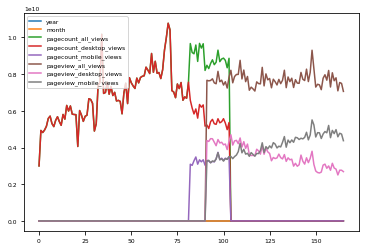

In [25]:
# quick visualization
plt.rcParams.update({'font.size':6})

plot_data.plot()

<AxesSubplot:xlabel='datetime'>

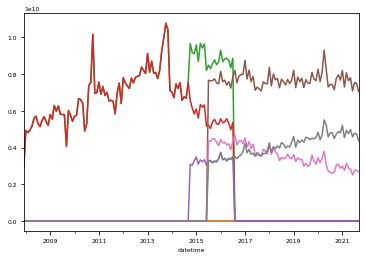

In [26]:
# convert YYYY and MM to datetime to plot as time series

plot_data['datetime'] = pd.to_datetime(plot_data['year'].astype(str) + plot_data['month'].astype(str), format='%Y%m')

plot_data.plot(x='datetime', legend=False)

In [27]:
# When do the two methods overlap?

plot_data[(plot_data['pagecount_all_views'] > 0) & (plot_data['pageview_all_views'] > 0)]

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views,datetime
91,2015,7,8.483699e+09,5.229226e+09,3.254473e+09,7.665422e+09,4.376667e+09,3.288755e+09,2015-07-01
92,2015,8,8.304022e+09,5.035534e+09,3.268488e+09,7.634815e+09,4.332482e+09,3.302333e+09,2015-08-01
93,2015,9,8.582061e+09,5.409631e+09,3.172430e+09,7.655695e+09,4.485492e+09,3.170203e+09,2015-09-01
94,2015,10,8.781787e+09,5.535704e+09,3.246083e+09,7.746032e+09,4.477533e+09,3.268499e+09,2015-10-01
95,2015,11,8.515191e+09,5.296956e+09,3.218235e+09,7.524321e+09,4.287720e+09,3.236601e+09,2015-11-01
96,2015,12,8.651858e+09,5.264446e+09,3.387412e+09,7.476287e+09,4.100012e+09,3.376275e+09,2015-12-01
97,2016,1,9.309261e+09,5.569633e+09,3.739629e+09,8.154016e+09,4.436179e+09,3.717837e+09,2016-01-01
98,2016,2,8.680941e+09,5.347709e+09,3.333231e+09,7.585859e+09,4.250997e+09,3.334862e+09,2016-02-01
99,2016,3,8.827530e+09,5.407676e+09,3.419854e+09,7.673275e+09,4.286590e+09,3.386684e+09,2016-03-01
100,2016,4,8.873621e+09,5.572235e+09,3.301385e+09,7.408148e+09,4.149384e+09,3.258764e+09,2016-04-01


In [28]:
# function to clean some of the plotting data
# scale to millions
# change 0 to NaNs so that the 0 values do not plot

def get_view_counts(view_type):
    
    views = plot_data[view_type].replace(0, np.nan)
    views = views/1000000
    
    return views

In [29]:
# name variables for ease of plotting

x = plot_data['datetime']

count_all = get_view_counts('pagecount_all_views')
count_web = get_view_counts('pagecount_desktop_views')
count_mobile = get_view_counts('pagecount_mobile_views')

view_all = get_view_counts('pageview_all_views')
view_web = get_view_counts('pageview_desktop_views')
view_mobile = get_view_counts('pageview_mobile_views')

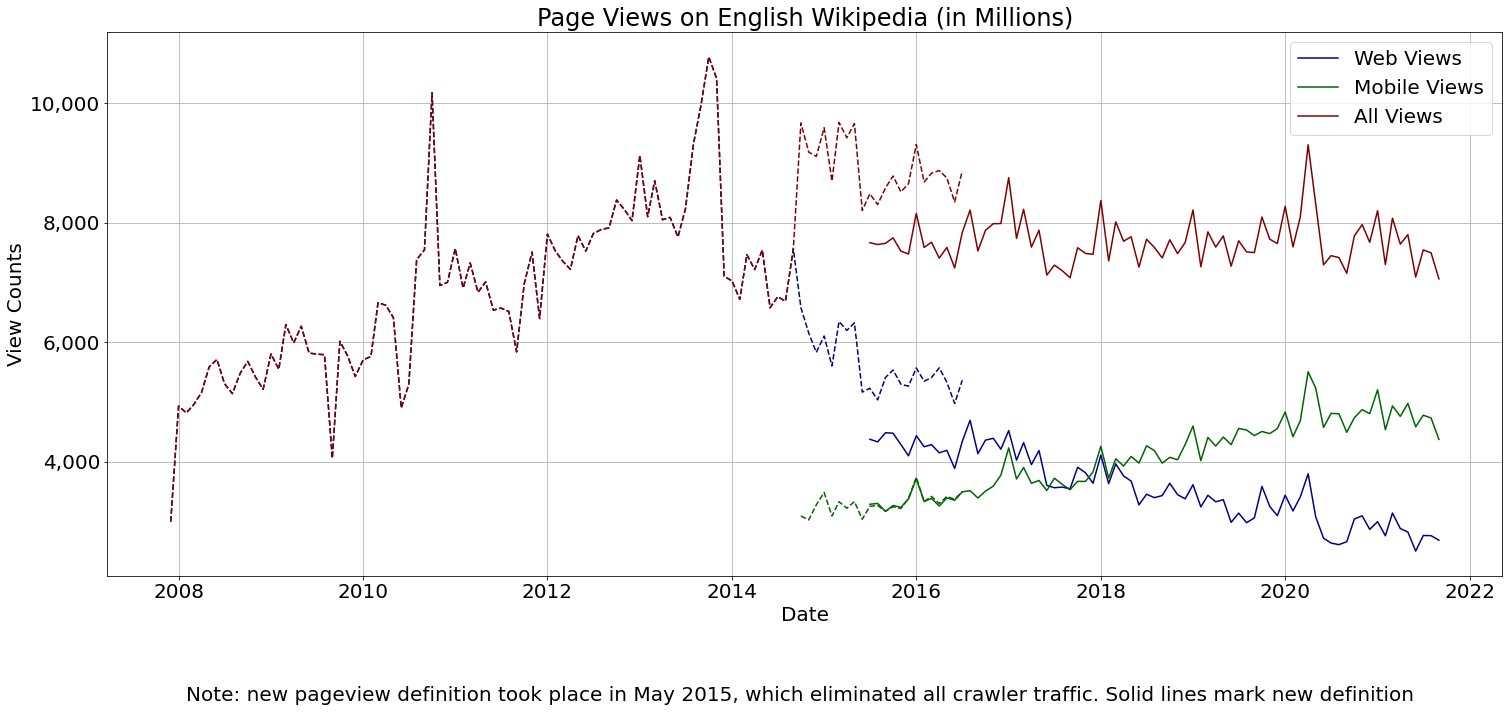

In [30]:
# plotting

plt.rcParams.update({'font.size':20})

fig = plt.figure(figsize=(25,10)) 
ax = fig.add_subplot()
plt.grid()


# add title
ax.set_title('Page Views on English Wikipedia (in Millions)')

# add axis labels
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('View Counts')
ax.set_xlabel('Date')

# annotation
ax.text(plot_data.datetime[2], min(plot_data.pagecount_all_views),
        "Note: new pageview definition took place in May 2015, which eliminated all crawler traffic. Solid lines mark new definition")

# plot
ax.plot(x, count_web, color='darkblue', linestyle='dashed')
ax.plot(x, count_mobile, color='darkgreen', linestyle='dashed')
ax.plot(x, count_all, color='maroon', linestyle='dashed')
ax.plot(x, view_web, color='darkblue', label='Web Views')
ax.plot(x, view_mobile, color='darkgreen', label='Mobile Views')
ax.plot(x, view_all, color='maroon', label='All Views')
plt.legend()